# 1. Import Libraries

In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [2]:
import re
import math
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler
from tqdm.notebook import tqdm
tqdm.pandas()

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, \
mean_squared_error, r2_score, mean_absolute_error, classification_report 

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, PassiveAggressiveClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    RandomForestClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download("vader_lexicon")

from faker import Faker


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 2. Load Data

In [3]:
data = pd.read_csv('../Dataset/reviewsdata.csv')
data

,Review
0,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...
3,"unique, great stay, wonderful time hotel monac..."
4,"great stay great stay, went seahawk game aweso..."
...,...
20486,"best kept secret 3rd time staying charm, not 5..."
20487,great location price view hotel great quick pl...
20488,"ok just looks nice modern outside, desk staff ..."
20489,hotel theft ruined vacation hotel opened sept ...


# 3. Initial Analysis

### 3.1. Metadata

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
dtypes: object(1)
memory usage: 160.2+ KB


In [5]:
data.isnull().sum()

Review    0
dtype: int64

In [ ]:
plt.subplots(figsize = (25,5))
ax = sns.countplot(data, y = data['label'])
ax.bar_label(ax.containers[0])
plt.show()

### 3.2. Processing Columns

In [4]:
stopword_en = pd.read_csv('../../en_stopword_1106.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()

def lower_text(text):
    return text.lower()

def alphanumeric_text(text):
    # return re.sub("[^a-z0-9\s]","", text)
    text = text.lower()
    return re.sub(r'[^\w\s.,]', '', text)

def remove_duplicate_words(text):
    return re.sub(r'\b(\w+)(\s+\1)+\b', r'\1', text)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'@[a-z0-9_]+', '', text) # Removes Twitter usernames
    text = re.sub('rt|cc', ' ', text)  # remove RT and cc
    text = re.sub('#\S+', '', text)  # remove hashtags
    text = re.sub('@\S+', '  ', text)  # remove mentions
    text = re.sub('\[.*?\]', '', text) # Removes all text enclosed in square brackets 
    text = re.sub('<.*?>+', '', text) # remove html tags
    text = re.sub('https?://\S+|www\.\S+', '', text) # remove URLs
    text = re.sub('\s+', ' ', text)  # remove extra whitespace
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuations
    text = re.sub(r'[^\w\s.,]', '', text) # Removes all non-word characters
    # text = [word for word in text.split(' ') if word not in nltk_stopword]
    return text


def stop_word(text):
    return " ".join([word for word in text.split(' ') if word not in stopword_list])

lemmatizer = WordNetLemmatizer()

def lemmatize_word(word):
    return lemmatizer.lemmatize(word, pos='v')

def lemmatize_sentence(sentence):
    words = nltk.word_tokenize(sentence) 
    words = [word for word in words if word.isalnum()] 
    words = [lemmatize_word(word) for word in words]  
    return ' '.join(words)  

In [5]:
data['clean_text'] = data['Review'] \
                    .progress_apply(clean_text) \
                    .progress_apply(stop_word) \
                    .progress_apply(lemmatize_sentence) \
                    # .progress_apply(lower_text) \
                    # .progress_apply(remove_duplicate_words) \
                    # .progress_apply(alphanumeric_text) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split(' ') if word not in (nltk_stopword)])) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split(' ') if len(word) >= 4])) \
                    # .progress_apply(lemmatizer) \
data

  0%|          | 0/20491 [00:00<?, ?it/s]

  0%|          | 0/20491 [00:00<?, ?it/s]

  0%|          | 0/20491 [00:00<?, ?it/s]

,Review,clean_text
0,nice hotel expensive parking got good deal sta...,nice hotel expensive park deal stay hotel anni...
1,ok nothing special charge diamond member hilto...,special charge diamond hilton decide chain sho...
2,nice rooms not 4* experience hotel monaco seat...,nice 4 experience hotel monaco seattle hotel n...
3,"unique, great stay, wonderful time hotel monac...",unique stay wonderful time hotel monaco locati...
4,"great stay great stay, went seahawk game aweso...",stay stay seahawk game awesome downfall view b...
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",secret 3rd time stay charm 5star nt beat time ...
20487,great location price view hotel great quick pl...,location price view hotel quick sightsdirectly...
20488,"ok just looks nice modern outside, desk staff ...",nice modern desk staff nt icularly friendly co...
20489,hotel theft ruined vacation hotel opened sept ...,hotel theft ruin vacation hotel sept 17 2007 g...


### 3.3. Add label for Sentiment Analysis using Vader NLTK

In [28]:
sentiments = SentimentIntensityAnalyzer()
data["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in data["clean_text"]]
data["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in data["clean_text"]]
data["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in data["clean_text"]]
data['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in data["clean_text"]]
data

C:\Users\indiz\AppData\Local\Temp\ipykernel_11280\471865155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in data["clean_text"]]
C:\Users\indiz\AppData\Local\Temp\ipykernel_11280\471865155.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in data["clean_text"]]
C:\Users\indiz\AppData\Local\Temp\ipykernel_11280\471865155.py:4: SettingWithCopyWarning: 
A value is trying to be s

,Review,clean_text,text_len,Positive,Negative,Neutral,Compound
0,nice hotel expensive parking got good deal sta...,nice hotel expensive park deal stay hotel anni...,66,0.262,0.070,0.667,0.9413
1,ok nothing special charge diamond member hilto...,special charge diamond hilton decide chain sho...,186,0.156,0.069,0.775,0.9578
2,nice rooms not 4* experience hotel monaco seat...,nice 4 experience hotel monaco seattle hotel n...,174,0.198,0.053,0.749,0.9801
3,"unique, great stay, wonderful time hotel monac...",unique stay wonderful time hotel monaco locati...,71,0.342,0.000,0.658,0.9837
4,"great stay great stay, went seahawk game aweso...",stay stay seahawk game awesome downfall view b...,143,0.206,0.097,0.697,0.9576
...,...,...,...,...,...,...,...
20485,not impressed unfriendly staff checked asked h...,impress unfriendly staff check floor 3rd floor...,62,0.175,0.223,0.601,-0.5994
20486,"best kept secret 3rd time staying charm, not 5...",secret 3rd time stay charm 5star nt beat time ...,86,0.238,0.040,0.722,0.9601
20487,great location price view hotel great quick pl...,location price view hotel quick sightsdirectly...,32,0.148,0.000,0.852,0.6369
20488,"ok just looks nice modern outside, desk staff ...",nice modern desk staff nt icularly friendly co...,47,0.201,0.065,0.735,0.8225


In [31]:
score = data["Compound"].values
sentiment = []
for i in score:
    if i >= 0 :
        sentiment.append('Positive')
    elif i < 0 :
        sentiment.append('Negative')
    # else:
    #     sentiment.append('Neutral')
data["Sentiment"] = sentiment
data.head()

C:\Users\indiz\AppData\Local\Temp\ipykernel_11280\2078397319.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Sentiment"] = sentiment


,Review,clean_text,text_len,Positive,Negative,Neutral,Compound,Sentiment
0,nice hotel expensive parking got good deal sta...,nice hotel expensive park deal stay hotel anni...,66,0.262,0.070,0.667,0.9413,Positive
1,ok nothing special charge diamond member hilto...,special charge diamond hilton decide chain sho...,186,0.156,0.069,0.775,0.9578,Positive
2,nice rooms not 4* experience hotel monaco seat...,nice 4 experience hotel monaco seattle hotel n...,174,0.198,0.053,0.749,0.9801,Positive
3,"unique, great stay, wonderful time hotel monac...",unique stay wonderful time hotel monaco locati...,71,0.342,0.000,0.658,0.9837,Positive
4,"great stay great stay, went seahawk game aweso...",stay stay seahawk game awesome downfall view b...,143,0.206,0.097,0.697,0.9576,Positive


In [32]:
print(data["Sentiment"].value_counts())

Positive    18125
Negative     1923
Name: Sentiment, dtype: int64


### 3.4. Count Sentence in a Record

4
1529


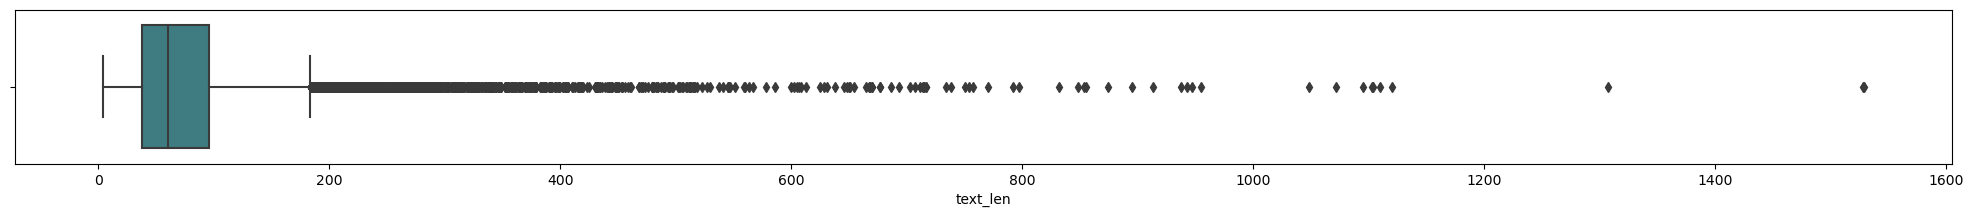

In [6]:
text_len = [len(word) for word in data['clean_text'].str.split(' ')]
data['text_len'] = pd.DataFrame(text_len)
print(data['text_len'].min())
print(data['text_len'].max())


fig, ax = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="crest")
plt.show()

In [27]:
print(data['text_len'].quantile(.01))
print(data['text_len'].quantile(.99))

15.0
305.52999999999884


In [23]:
len(data[data['text_len'] > 96])

5119

### 3.5. Remove outliers based-on length of the sentences

<Axes: xlabel='text_len'>

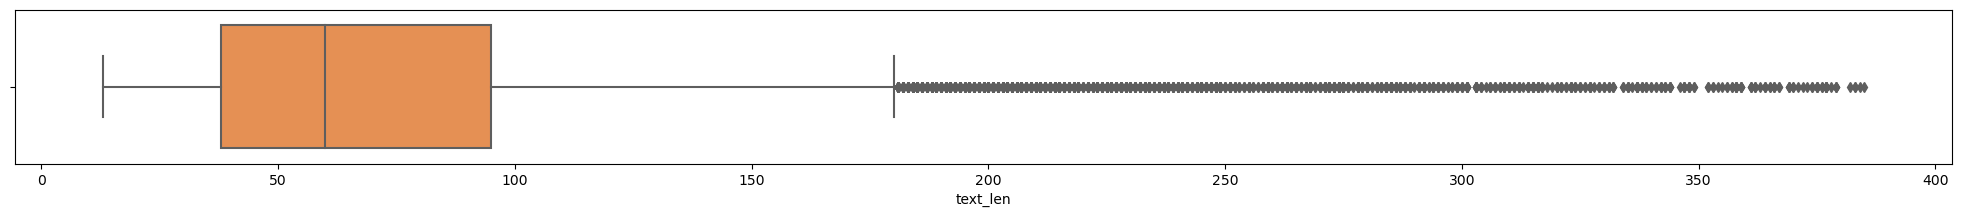

In [26]:
Q1 = data['text_len'].quantile(.01)
Q3 = data['text_len'].quantile(.99)

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x = data['text_len'], palette="Oranges")

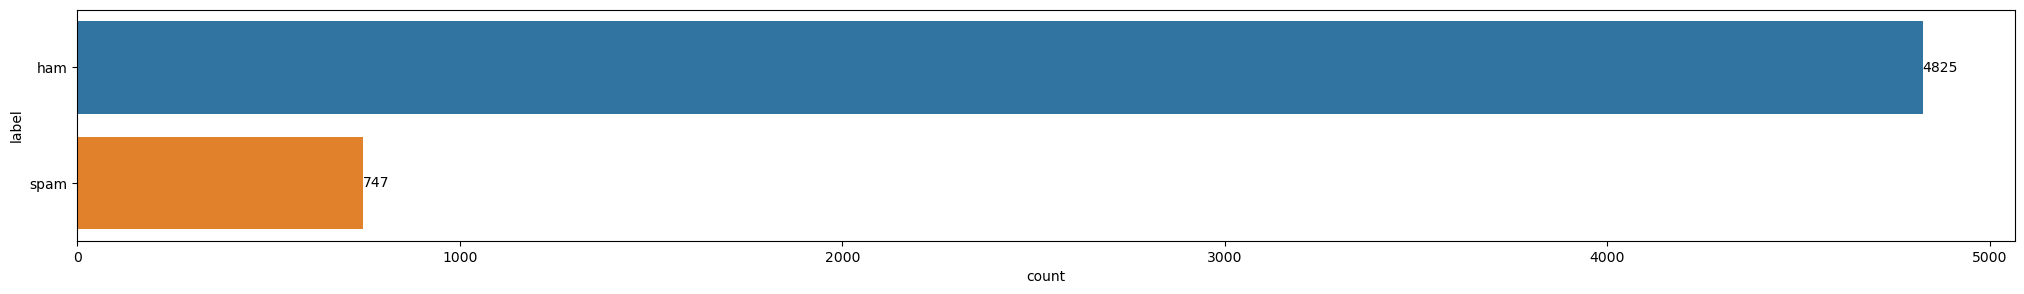

In [16]:
plt.subplots(figsize = (25,3))
ax = sns.countplot(data, y = data['label'])
ax.bar_label(ax.containers[0])
plt.show()

# 4. Preparing Dataset

In [33]:
LE = LabelEncoder()

X = data['clean_text']
# Y = LE.fit_transform(data['label']) ### For Classification Algoritms
Y = pd.get_dummies(data['Sentiment']) ### For Deep Learning Algoritms
# Y = data['label'] ### For Deep Learning Algoritms

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(14073,) (14073, 2)
(3970,) (3970, 2)
(2005,) (2005, 2)


In [35]:
vocab_size = 7979
embedding_dim = 128
max_length = 400
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
num_label = y_train.shape[1]

In [ ]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

In [38]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

# Undersampling
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

training_padded, training_label = rus.fit_resample(training_padded, training_label)
testing_padded, testing_label = rus.fit_resample(testing_padded, testing_label)
validating_padded, validating_label = rus.fit_resample(validating_padded, validating_label)

# Categorical Label
training_label = pd.get_dummies(training_label.reshape(-1)).values
testing_label = pd.get_dummies(testing_label.reshape(-1)).values
validating_label = pd.get_dummies(validating_label.reshape(-1)).values

print(training_padded.shape, training_label.shape)
print(testing_padded.shape, testing_label.shape)
print(validating_padded.shape, validating_label.shape)


69922
(2674, 400) (2674, 2)
(784, 400) (784, 2)
(388, 400) (388, 2)


# 5. Deep Learning Model

In [39]:
def DNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(num_label, activation='softmax'))
    return model


def CNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(num_label, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Bidirectional(LSTM(256)))
    model.add(Dense(num_label, activation='softmax'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    # model.add(Bidirectional(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True)))
    model.add(Bidirectional(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    model.add(Dense(num_label, activation='softmax'))
    return model

# model = DNN_Model()
# model = CNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

opt = Adam(learning_rate = 0.000_1)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 128)          1021312   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              198144    
 l)                                                              
                                                                 
 dense (Dense)               (None, 2)                 514       
                                                                 
Total params: 1,219,970
Trainable params: 1,219,970
Non-trainable params: 0
_________________________________________________________________


In [40]:
num_epoch = 10
batch_size = 64
history = model.fit(training_padded, training_label, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (validating_padded, validating_label))

Epoch 1/10
42/42 [==============================] - 8s 94ms/step - loss: 0.6911 - accuracy: 0.5490 - val_loss: 0.6864 - val_accuracy: 0.6907
Epoch 2/10
42/42 [==============================] - 4s 87ms/step - loss: 0.6841 - accuracy: 0.6799 - val_loss: 0.6779 - val_accuracy: 0.6830
Epoch 3/10
42/42 [==============================] - 4s 85ms/step - loss: 0.6713 - accuracy: 0.7397 - val_loss: 0.6589 - val_accuracy: 0.7448
Epoch 4/10
42/42 [==============================] - 3s 81ms/step - loss: 0.6293 - accuracy: 0.7741 - val_loss: 0.5394 - val_accuracy: 0.8067
Epoch 5/10
42/42 [==============================] - 3s 80ms/step - loss: 0.4820 - accuracy: 0.8227 - val_loss: 0.4319 - val_accuracy: 0.8582
Epoch 6/10
42/42 [==============================] - 3s 78ms/step - loss: 0.3643 - accuracy: 0.8785 - val_loss: 0.3435 - val_accuracy: 0.8737
Epoch 7/10
42/42 [==============================] - 3s 82ms/step - loss: 0.2569 - accuracy: 0.9061 - val_loss: 0.2805 - val_accuracy: 0.8814
Epoch 8/10
42

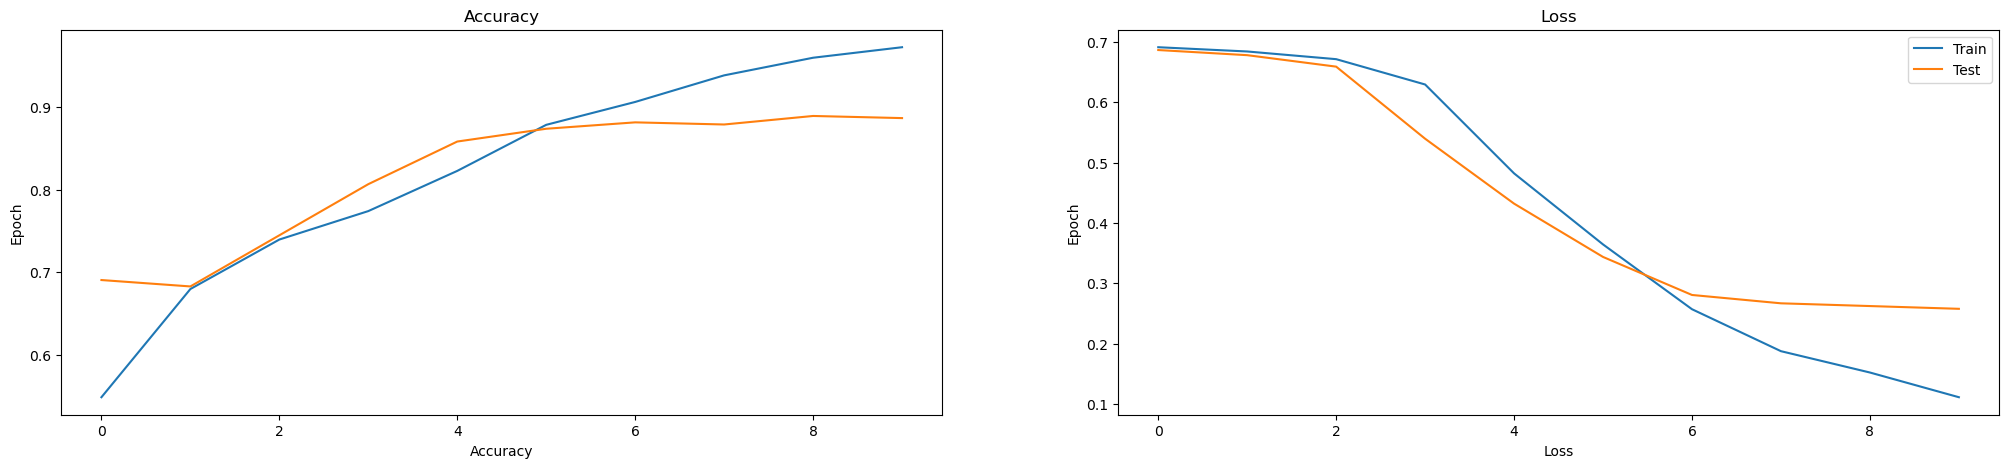

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [42]:
train_predictions = np.rint(model.predict(testing_padded, verbose=0)).argmax(axis=1).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label.argmax(axis=1)})
train_results['Diff'] = train_results['Actuals'] == train_results['Train Predictions']
print(train_results.head(5))
train_results['Diff'].value_counts()

   Train Predictions  Actuals  Diff
0                  0        0  True
1                  0        0  True
2                  0        0  True
3                  0        0  True
4                  0        0  True


True     690
False     94
Name: Diff, dtype: int64

In [43]:
y_pred = model.predict(testing_padded, verbose=0).argmax(axis=1)
print(classification_report(testing_label.argmax(axis=1),y_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       392
           1       0.91      0.84      0.88       392

    accuracy                           0.88       784
   macro avg       0.88      0.88      0.88       784
weighted avg       0.88      0.88      0.88       784



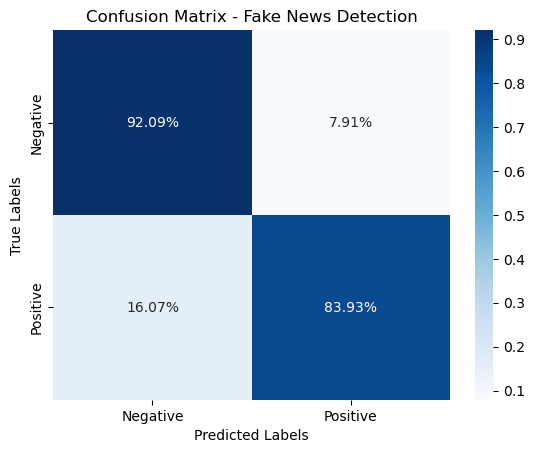

In [44]:
labels = y_train.columns

y_pred = np.rint(model.predict(testing_padded, verbose=0)).argmax(axis=1).flatten()
con_mat = confusion_matrix(testing_label.argmax(axis=1),y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

# 6. Classification Algoritms

In [63]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=42)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)
linear = LinearRegression()
pac = PassiveAggressiveClassifier(random_state=42)

model = StackingClassifier([
    ('XGB', XGB),
    ('randomforest', randomForest),
    ('histGradientBoosting', histGradientBoosting),
    ('adaboost', adaboost),
    ('bagging', bagging),
    ('extraTres', extraTrees),
    ('knn', knn),
    ('decisionTree', decisionTree),
    # ('pac', pac),
    # ('linear', linear),
    # ('gradient', gradient),

], n_jobs=-1)

In [64]:
model.fit(training_padded, training_label)

StackingClassifier(estimators=[('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                               ('histGradientBoosting',
                                HistGradientBoostingClassifier()),
                               ('adaboost',
                                AdaBoostClassifier(n_estimators=100,
                                                   random_state=42)),
                               ('bagging', BaggingClassifier(n_jobs=-1)),
                               ('extraTres',
                                ExtraTreesClassifier(max_depth=100, n_jobs=-1,
                                                     random_state=42)),
                               ('knn', KNeighborsClassifier(n_jobs=-1)),
                               ('decisionTree',
                                DecisionTreeClassifier(max_depth=100,
                                                       random_state=42))],
                   n_jobs=-1)

In [65]:
print("Train Score        :",round((model.score(training_padded, training_label)*100), 2),'%')
print("Test Score         :",round((model.score(testing_padded, testing_label)*100), 2),'%')

y_pred = model.predict(testing_padded)

print("R Squared Error    :",round(r2_score(testing_label, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(testing_label, y_pred), 2))
print("Mean Absolute Error:",round(mean_absolute_error(testing_label, y_pred), 2))

Train Score        : 100.0 %
Test Score         : 85.2 %
R Squared Error    : 0.41
Mean Squared Error : 0.15
Mean Absolute Error: 0.15


In [66]:
train_predictions = model.predict(testing_padded).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label})
train_results['Diff'] = train_results['Actuals'] == train_results['Train Predictions']
print(train_results.head(5))
train_results['Diff'].value_counts()

   Train Predictions  Actuals   Diff
0                  1        0  False
1                  1        0  False
2                  1        0  False
3                  0        0   True
4                  0        0   True


True     259
False     45
Name: Diff, dtype: int64

In [67]:
y_pred = model.predict(testing_padded)
print(classification_report(y_pred,testing_label))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       143
           1       0.88      0.83      0.86       161

    accuracy                           0.85       304
   macro avg       0.85      0.85      0.85       304
weighted avg       0.85      0.85      0.85       304



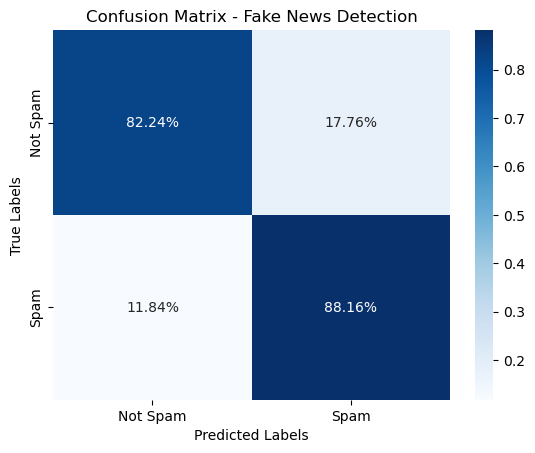

In [68]:
labels = ['Not Spam','Spam']

y_pred = np.rint(model.predict(testing_padded))
con_mat = confusion_matrix(testing_label,y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()